In [1]:
!pip install visualkeras seaborn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [3]:
tf.keras.backend.clear_session()

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'

In [5]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

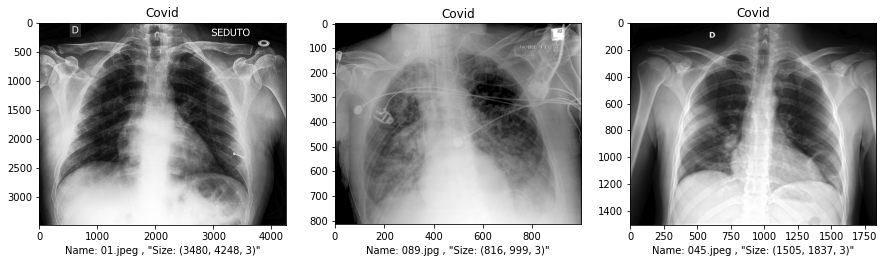

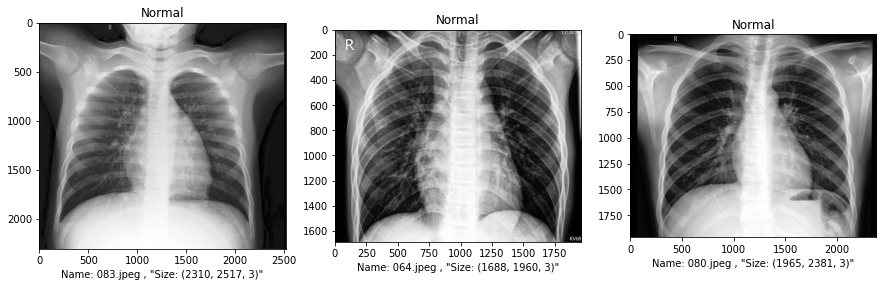

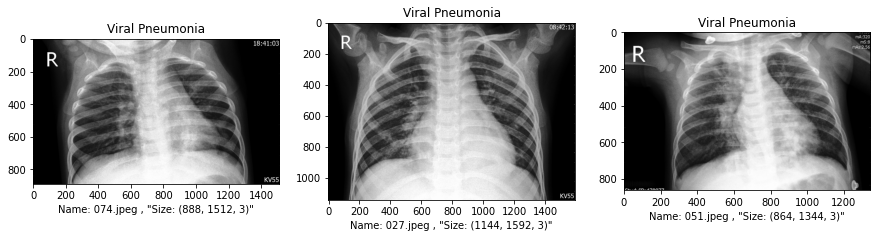

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [9]:
img_size = 512
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
base_model = ResNet152V2(weights='imagenet', include_top=False,
                         input_shape=(img_size, img_size, 3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(512 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256 , activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [11]:
!pip install pydot

In [12]:
model.summary() # 307 + 12 = 319 layers

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_out (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 128, 128, 25  1024       ['conv2_block2_out[0][0]']       
 ormalization)                  6)                                                                
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 128, 128, 25  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16384       ['conv2_block3_preact_relu[0][0]'
          

 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 66, 66, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 64, 64, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block5_preact_relu (Acti  (None, 64, 64, 512)  0          ['conv3_block5_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, 64, 64, 128)  65536       ['conv3_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)       

 n)                                                                                               
                                                                                                  
 conv3_block7_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block7_2_relu[0][0]']    
                                                                                                  
 conv3_block7_out (Add)         (None, 64, 64, 512)  0           ['conv3_block6_out[0][0]',       
                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 64, 64, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 34, 34, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block4_out (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_conv[0][0]']    
                                                                                                  
 conv4_block5_preact_bn (BatchN  (None, 32, 32, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 32, 32, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
          

                                                                                                  
 conv4_block7_2_pad (ZeroPaddin  (None, 34, 34, 256)  0          ['conv4_block7_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 32, 32, 256)  589824      ['conv4_block7_2_pad[0][0]']     
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)       

 Normalization)                 )                                                                 
                                                                                                  
 conv4_block10_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block10_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
          

 conv4_block12_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block12_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block12_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 32, 32, 1024  0           ['conv4_block11_out[0][0]',      
          

                                                                 ']                               
                                                                                                  
 conv4_block15_1_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 34, 34, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
          

 conv4_block17_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block17_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block17_out (Add)        (None, 32, 32, 1024  0           ['conv4_block16_out[0][0]',      
                                )                                 'conv4_block17_3_conv[0][0]']   
                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 32, 32, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation) 

 on)                                                                                              
                                                                                                  
 conv4_block20_2_pad (ZeroPaddi  (None, 34, 34, 256)  0          ['conv4_block20_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 32, 32, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block23_preact_bn (Batch  (None, 32, 32, 1024  4096       ['conv4_block22_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block23_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block23_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block25_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block25_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block25_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block28_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block28_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 34, 34, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block30_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block30_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block30_out (Add)        (None, 32, 32, 1024  0           ['conv4_block29_out[0][0]',      
                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 32, 32, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_pad (ZeroPaddi  (None, 34, 34, 256)  0          ['conv4_block33_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 32, 32, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block36_preact_bn (Batch  (None, 32, 32, 1024  4096       ['conv4_block35_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block36_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block36_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_pad (ZeroPaddin  (None, 18, 18, 512)  0          ['conv5_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 16, 16, 512)  2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
          

Total params: 62,398,979
Trainable params: 4,067,331
Non-trainable params: 58,331,648
__________________________________________________________________________________________________


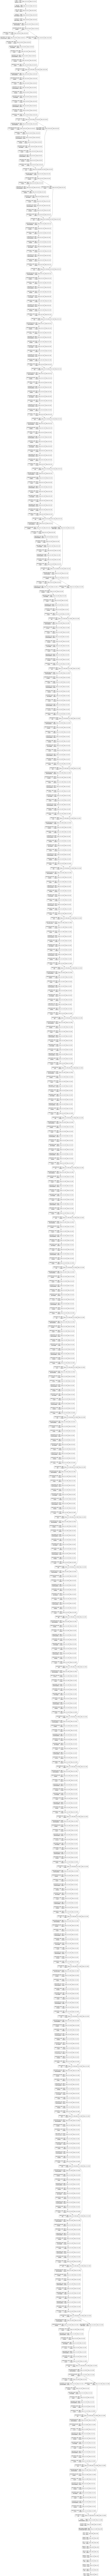

In [13]:
plot_model(model, to_file='./images/resnet_model.png', show_shapes=True, show_layer_names=True)

In [14]:
visualkeras.layered_view(model, legend=True)

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1), 
             ModelCheckpoint('./models/resnet_model.h5', save_best_only=True)]

In [16]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
DISABLE_GPU = True
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 28s 1s/step - loss: 1.7594 - accuracy: 0.3466 - val_loss: 1.1205 - val_accuracy: 0.5152
Epoch 2/100
16/16 [==============================] - 16s 987ms/step - loss: 1.9813 - accuracy: 0.3546 - val_loss: 0.9933 - val_accuracy: 0.3939
Epoch 3/100
16/16 [==============================] - 17s 1s/step - loss: 1.3505 - accuracy: 0.4303 - val_loss: 0.9714 - val_accuracy: 0.5909
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 1.1212 - accuracy: 0.4303 - val_loss: 0.9335 - val_accuracy: 0.5909
Epoch 5/100
16/16 [==============================] - 18s 1s/step - loss: 1.0027 - accuracy: 0.4701 - val_loss: 0.7867 - val_accuracy: 0.6970
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 0.8163 - accuracy: 0.6056 - val_loss: 0.6570 - val_accuracy: 0.6970
Epoch 7/100
16/16 [==============================] - 18s 1s/step - loss: 0.6783 - accuracy: 0.6853 - val_loss: 0.5150 - val_accuracy: 0.7121
Epoch 8/10

In [19]:
model = load_model('./models/resnet_model.h5')

In [20]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

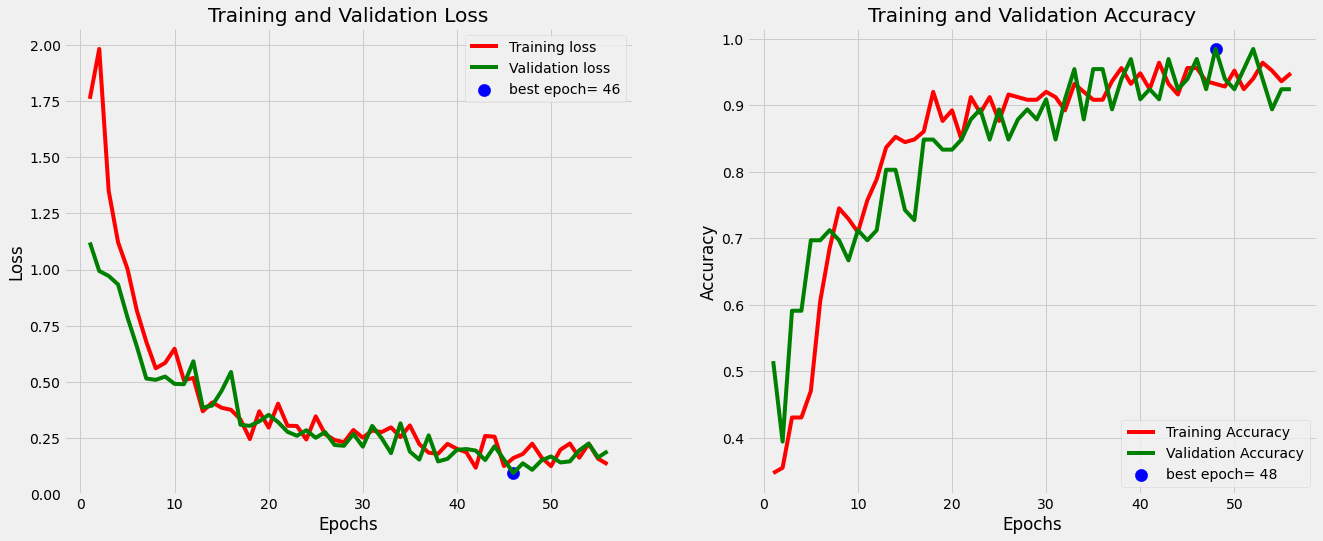

In [21]:
tr_plot(history, 0)

In [22]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 6s 61ms/step - loss: 0.0943 - accuracy: 0.9697
Loss: 9.430
Accuracy: 96.970


In [23]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [24]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [25]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [26]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [27]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[25  0  0]
 [ 1 20  1]
 [ 0  0 19]]


F1 Score: 0.9693182634359105


                 precision    recall  f1-score   support

          Covid       0.96      1.00      0.98        25
         Normal       1.00      0.91      0.95        22
Viral Pneumonia       0.95      1.00      0.97        19

       accuracy                           0.97        66
      macro avg       0.97      0.97      0.97        66
   weighted avg       0.97      0.97      0.97        66



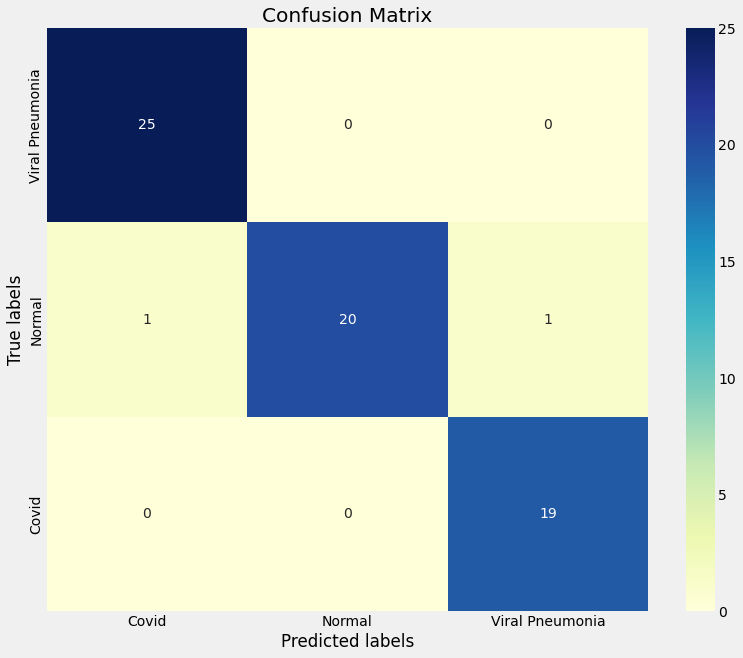

In [28]:
cal_score(model, plot=True)